In [211]:
%matplotlib inline
import pandas as pd
import sklearn
import numpy as np
from IPython.display import display
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scipy.stats as stats
import seaborn as sns
sns.set(style="darkgrid")

In [44]:
from pythainlp.tag.named_entity import ThaiNameTagger

In [144]:
the_standard = pd.read_csv('../../data/the_standard_data.csv')

In [145]:
thai_pbs = pd.read_csv('../../data/Thaipbs-tokenize_include_stop.csv')

In [146]:
train_data = pd.concat([the_standard,thai_pbs[:4*len(thai_pbs)//5]])
test_data = pd.concat([thai_pbs[4*len(thai_pbs)//5:]])

/Users/tomfoolery/Documents/Study/py37_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [147]:
ner_tagger = ThaiNameTagger()

In [250]:
boundary = 2000
data_bounded = train_data[train_data['view']<boundary]
x = data_bounded['view']
std = np.std(x)
mean = np.mean(x)
groups = [mean-1*std-157.08,mean-0.85*std,mean-0.7*std,mean-0.35*std,mean,mean+std,mean+3*std]
print('STD : ',std)
print('MEAN : ',mean)
print(groups)

STD :  506.6089725616039
MEAN :  663.6907290958532
[0.0017565342492673608, 233.0731024184899, 309.06444830273045, 486.3775886992918, 663.6907290958532, 1170.299701657457, 2183.517646780665]


In [251]:
pop_level = []
for i in x:
    for j in range(len(groups)-1):
        if i >= groups[j] and i <= groups[j+1]:
            pop_level+=[j]

In [252]:
print(np.unique(pop_level,return_counts=True))

(array([0, 1, 2, 3, 4, 5]), array([4718, 2557, 4373, 3044, 4566, 4275]))


## Prepare Data

In [253]:
headlines = data_bounded['headline']
views = data_bounded['view']
dow = data_bounded['DOW']

In [255]:
ner = set()
pos = set()
for hl in [ner_tagger.get_ner(i) for i in headlines]:
    for word in hl:
        ner.add(word[1])
        pos.add(word[2])

In [256]:
ner = list(ner)
pos = list(pos)
ner_idx = [i for i in range(1,len(ner)+1)]
pos_idx = [i for i in range(1,len(pos)+1)]
dow_idx = [i for i in range(1,len(list(set(dow)))+1)]

In [257]:
ner_to_idx = dict(zip(ner,ner_idx))
idx_to_ner = {v: k for k, v in ner_to_idx.items()}

pos_to_idx = dict(zip(pos,pos_idx))
idx_to_pos = {v: k for k, v in pos_to_idx.items()}

dow_to_idx = dict(zip(list(set(dow)),dow_idx))
idx_to_dow = {v: k for k, v in dow_to_idx.items()}

In [258]:
def prepare_x(data):
    data_ner = [ner_tagger.get_ner(i) for i in data]
    x = []
    
    for idx in range(len(data_ner)):
        temp = []
        for word in data_ner[idx]:
            temp+=[ner_to_idx[word[1]]]
            temp+=[pos_to_idx[word[2]]]
            temp+=[dow_to_idx[dow.iloc[idx]]]
        x+=[temp]
    return x

In [259]:
def prepare_y(data):
    y = []
    for i in data:
        c = 0
        for j in range(len(groups)-1):
            if i >= groups[j] and i <= groups[j+1]:
                y+=[j]
                c=1
                break
        if c==0:
            y+=[0]
        
    return y

In [260]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

x_train = prepare_x(headlines)
y_train = prepare_y(views)

x_train = pad_sequences(x_train, maxlen=130)
y_train = to_categorical(y_train)

x_test = prepare_x(test_data['headline'])
y_test = prepare_y(test_data['view'])

x_test = pad_sequences(x_test, maxlen=130)
y_test = to_categorical(y_test)

print('x_train shape : ',x_train.shape)
print('y_train shape : ',y_train.shape)

print('x_test shape : ',x_test.shape)
print('y_test shape : ',y_test.shape)

x_train shape :  (23536, 130)
y_train shape :  (23536, 6)
x_test shape :  (5595, 130)
y_test shape :  (5595, 6)


## Model

In [264]:
from keras.models import Model, Input
from keras.layers import Dense, Dropout, BatchNormalization, GRU, Conv1D, Dropout
from keras.optimizers import Adam
def get_model():    
    input1 = Input(shape=(x_train.shape[1],))
#     x = Conv1D(16,3)(input1)
#     x = GRU(32)(x)
#     x = Flatten()(x)
    x = Dense(1024, activation='relu')(input1)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
#     x = Dense(64, activation='relu')(x)
#     x = Dropout(0.2)(x)
    x = Dense(y_train.shape[1],activation='softmax')(x)
    model = Model(inputs=input1, outputs=x)
    adam  = Adam(lr=0.00001)
    model.compile(optimizer=adam,  loss='categorical_crossentropy' ,metrics=['accuracy'])
    
    
    return model

In [265]:
model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 130)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 1024)              134144    
_________________________________________________________________
dropout_44 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_57 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_45 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_46 (Dropout)         (None, 256)               0         
__________

In [267]:
model.fit(x_train, y_train, batch_size=32 ,epochs=50, verbose=2, validation_split=0.1)

Train on 21182 samples, validate on 2354 samples
Epoch 1/50
 - 4s - loss: 2.7671 - acc: 0.1759 - val_loss: 1.8091 - val_acc: 0.1610
Epoch 2/50
 - 3s - loss: 2.4109 - acc: 0.1775 - val_loss: 1.7883 - val_acc: 0.1754
Epoch 3/50
 - 3s - loss: 2.1997 - acc: 0.1803 - val_loss: 1.7872 - val_acc: 0.1805
Epoch 4/50
 - 4s - loss: 2.0845 - acc: 0.1839 - val_loss: 1.7902 - val_acc: 0.1691
Epoch 5/50
 - 4s - loss: 2.0107 - acc: 0.1819 - val_loss: 1.7901 - val_acc: 0.1733
Epoch 6/50
 - 4s - loss: 1.9577 - acc: 0.1804 - val_loss: 1.7929 - val_acc: 0.1487
Epoch 7/50
 - 4s - loss: 1.9228 - acc: 0.1821 - val_loss: 1.7972 - val_acc: 0.1372
Epoch 8/50
 - 4s - loss: 1.8883 - acc: 0.1848 - val_loss: 1.7985 - val_acc: 0.1393
Epoch 9/50
 - 4s - loss: 1.8693 - acc: 0.1882 - val_loss: 1.7943 - val_acc: 0.1495
Epoch 10/50
 - 4s - loss: 1.8602 - acc: 0.1849 - val_loss: 1.7947 - val_acc: 0.1449
Epoch 11/50
 - 3s - loss: 1.8418 - acc: 0.1870 - val_loss: 1.7928 - val_acc: 0.1444
Epoch 12/50
 - 4s - loss: 1.8306 - a

## Result

In [241]:
y_pred = model.predict(x_test)

In [242]:
def evaluate(y_pred,y_test):
    correct = 0
    wrong = 0
    count = [0,0,0,0,0]
    for i in range(len(y_pred)):
        p_level_pred = np.argmax(y_pred[i])
        p_level_test = np.argmax(y_test[i])
        count[p_level_pred]+=1
        if(p_level_pred == p_level_test):
            correct += 1
        else:
            wrong +=1
    print(count)
    return correct/(correct+wrong)

In [243]:
# p_level = np.argmax(y_pred[0])
# print('Pop Level : ',p_level)
# print('Pred Range : %f - %f' % (groups[p_level], groups[p_level+1]))
# print('Real View : %d' % (202))
print(evaluate(y_pred, y_test))

[2294, 3300, 1, 0, 0]
0.3944593386952636


In [209]:
#We test how the model works by creating a dataframe from the sample. The df is then used as source for the seaborn plot below
df_someXdata = pd.DataFrame([np.argmax(i) for i in y_pred],[np.argmax(i) for i in y_test])
df_someXdata.reset_index(level=0, inplace=True)
df_someXdata_LR = df_someXdata.rename(index=str, columns={"index": "Actual views", 0: "Predicted views"})
# df_someXdata_LR[:50]

AttributeError: module 'seaborn' has no attribute 'plt'

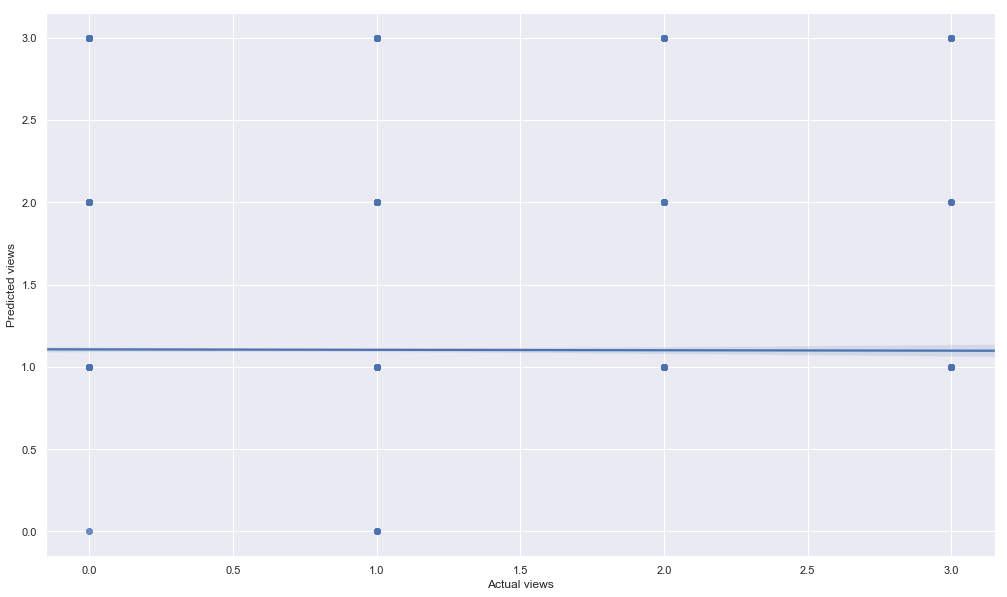

In [212]:
f, ax = plt.subplots(figsize=(17, 10))
sns.regplot(x=df_someXdata_LR["Actual views"], y=df_someXdata_LR["Predicted views"])
sns.plt.show()

## Try GRU

In [402]:
from keras.models import Model, Input
from keras.layers import Dense, Dropout, BatchNormalization, GRU, Conv1D, Dropout, TimeDistributed, LSTM
from keras.optimizers import Adam
def get_model_gru():    
    input1 = Input(shape=(x_train.shape[1],))
    x = LSTM(32)(input1)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(y_train.shape[1],activation='softmax')(x)
    model = Model(inputs=input1, outputs=x)
    adam  = Adam(lr=0.00001)
    model.compile(optimizer=adam,  loss='categorical_crossentropy' ,metrics=['accuracy'])
    
    
    return model

In [403]:
model = get_model_gru()
model.summary()

ValueError: Input 0 is incompatible with layer lstm_1: expected ndim=3, found ndim=2